# Instructions: 
1. For feature selections, run generate_train_test(*lag*, *weekly/monthly/daily*, *datasets used*) to generate training and testing dataset 
2. Uncomment .tocsv lines in the function to transform training and testing df to csv files.
3. Refer to last line of code for example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.linear_model import LinearRegression

In [2]:
# datasets chosen - tech companies
df_aapl = pd.read_csv('../datasets/stocks/AAPL.csv')
df_ggl = pd.read_csv('../datasets/stocks/GOOGL.csv')
df_msft = pd.read_csv('../datasets/stocks/MSFT.csv')

Text(0, 0.5, 'Close Price')

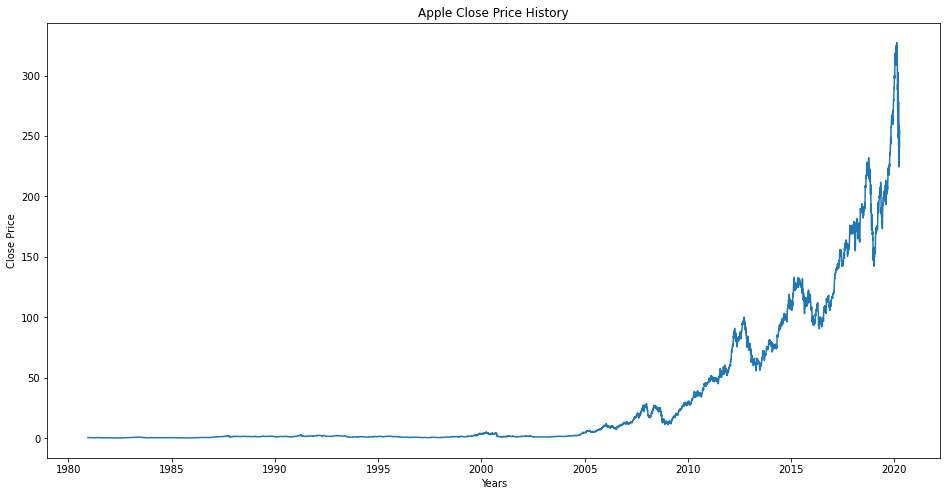

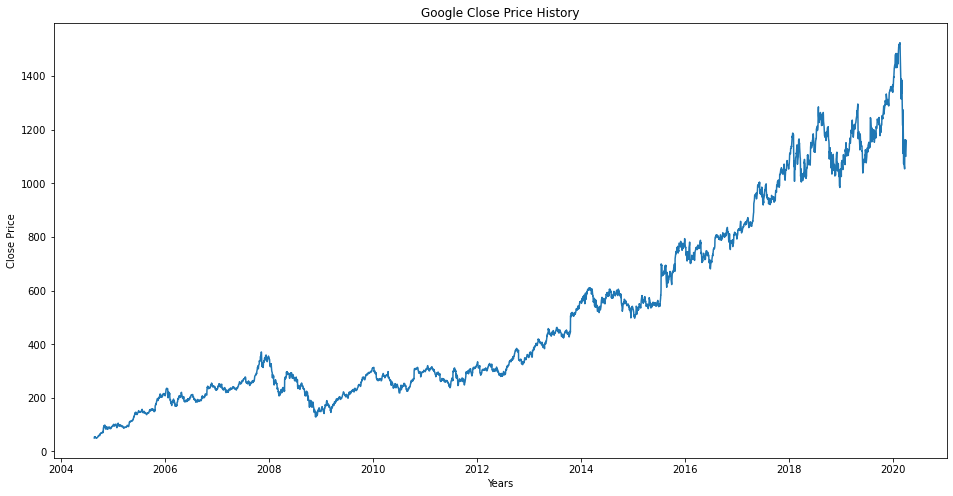

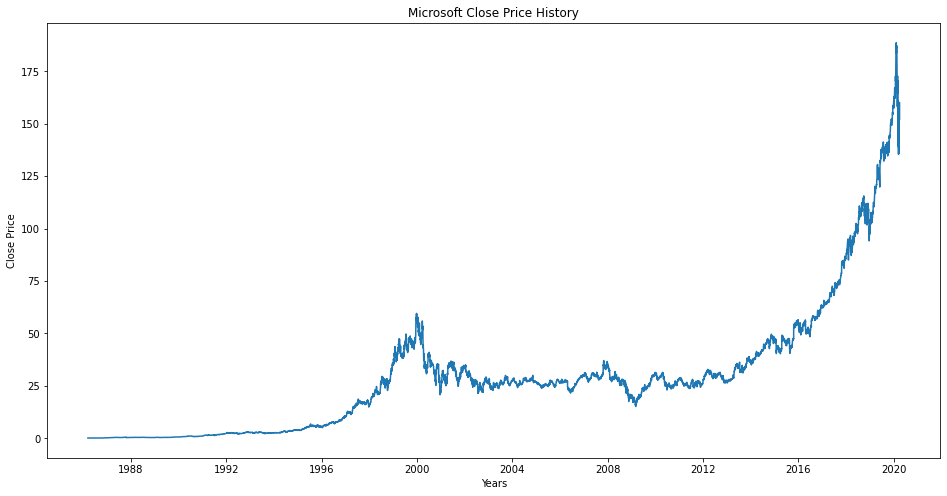

In [3]:
# apple
df_aapl['Date'] = pd.to_datetime(df_aapl.Date,format='%Y-%m-%d')
df_aapl.index = df_aapl['Date']
plt.figure(figsize=(16,8))
plt.plot(df_aapl['Close'])
plt.title("Apple Close Price History")
plt.xlabel("Years")
plt.ylabel("Close Price")

# google
df_ggl['Date'] = pd.to_datetime(df_ggl.Date,format='%Y-%m-%d')
df_ggl.index = df_ggl['Date']
plt.figure(figsize=(16,8))
plt.plot(df_ggl['Close'])
plt.title("Google Close Price History")
plt.xlabel("Years")
plt.ylabel("Close Price")

# microsoft
df_msft['Date'] = pd.to_datetime(df_msft.Date,format='%Y-%m-%d')
df_msft.index = df_msft['Date']
plt.figure(figsize=(16,8))
plt.plot(df_msft['Close'])
plt.title("Microsoft Close Price History")
plt.xlabel("Years")
plt.ylabel("Close Price")

In [4]:
def split(df):
    train_size = round(len(df)*0.7)
    y_movement = df['movement']
    y_t = df['Close (t)']
    X_colnames = df.drop(['Close (t)', 'movement'], axis=1).columns
    X = df[X_colnames]

    # for movement
    X_train, X_test, y_train_movement, y_test_movement = X[:train_size], X[train_size:], y_movement[:train_size], y_movement[train_size:]

    # for t
    X_train, X_test, y_train_t, y_test_t = X[:train_size], X[train_size:], y_t[:train_size], y_t[train_size:]
    train_df = pd.concat([X_train,y_train_t,y_train_movement],axis = 1)
    test_df = pd.concat([X_test,y_test_t, y_test_movement],axis = 1)
    return train_df, test_df

In [5]:
def shift(df, n):
    new_df = pd.DataFrame()
    # volume
    vol = "Volume (t-"+str(n)+")"
    new_df[vol] = df['Volume']
    for i in range(n-1,0,-1):
        v = "Volume (t-"+str(i)+")"
        new_df[v] = df['Volume'].shift(-(n-i))

    # close price
    p = "Close (t-"+str(n)+")"
    new_df[p] = df['Close']
    for i in range(n-1,0,-1):
        v = "Close (t-"+str(i)+")"
        new_df[v] = df['Close'].shift(-(n-i))

    # y-variable (close price)
    new_df['Close (t)'] = df['Close'].shift(-n)
    new_df = new_df.dropna()

    # y-variable (movement)
    new_df['movement'] = np.where(new_df["Close (t)"] > new_df['Close (t-1)'], 1, 0)
    return new_df


In [6]:
# Automate pipeline to generate training and testing datasets based on lag
def generate_train_test(lag, datasets, avg = "weekly"):
    """
    Return the training and testing dataset, uncomment to transform df to csv after feature selections
    """
    train_all = pd.DataFrame()
    test_all = pd.DataFrame()
    for df in datasets:
        if avg == "weekly":
            df = df.resample('W').mean()
        elif avg == "monthly":
            df = df.resample('M').mean()
        #else, daily, noneed groupby
        df = shift(df, lag)
        train_df, test_df = split(df)
        train_all = pd.concat([train_all, train_df])
        test_all = pd.concat([test_all, test_df])
    #train_all.to_csv(str(lag)+"_"+avg+"_train.csv")
    #test_all.to_csv(str(lag)+"_"+avg+"_test.csv")
    return train_all, test_all


In [7]:
# Remove data where price stagnant
df_aapl = df_aapl[(df_aapl['Date'] >= '2005-01-01')]
df_msft = df_msft[(df_msft['Date'] >= '1998-01-01')]

## Linear Regression on Stock

In [8]:
def linear_regression(name, df_stock, lag, aggr_fun='weekly'):
    train_stock, test_stock = generate_train_test(lag, df_stock, aggr_fun)

    model_stock = LinearRegression()
    x_train_stock = train_stock.drop(['Close (t)', 'movement'], axis=1)
    y_train_stock = train_stock['Close (t)']
    model_stock.fit(x_train_stock, y_train_stock)

    # features should exclude 'movement' and 'Close (t)'
    x_test_stock = test_stock.drop(['Close (t)', 'movement'], axis=1)
    y_test_stock = test_stock['Close (t)']

    preds_stock = model_stock.predict(x_test_stock)
    rms_stock = np.sqrt(np.mean(np.power((np.array(y_test_stock)-np.array(preds_stock)),2)))

    print(name, aggr_fun.capitalize(), 'RMS:', rms_stock)

    # plot
    df_results = pd.DataFrame()
    df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'] = test_stock['Close (t)']
    df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'] = preds_stock

    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'])
    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'])

    plt.title(name+' '+aggr_fun.capitalize()+' with sliding window '+str(lag))
    
    plt.ylabel('Close',fontsize=18)
    plt.legend([name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)', name+' '+aggr_fun.capitalize()+' Price Prediction'])
    plt.show()

    move_test_stock = test_stock['movement']

    pred_move_stock = (preds_stock - test_stock["Close (t-1)"]) 
    pred_move_stock = pred_move_stock.where(pred_move_stock<0, 1).where(pred_move_stock>=0, 0).astype(int)

    precision = precision_score(move_test_stock, pred_move_stock)
    recall = recall_score(move_test_stock, pred_move_stock)
    accuracy = accuracy_score(move_test_stock, pred_move_stock)
    f1 = f1_score(move_test_stock, pred_move_stock)
    
    print(confusion_matrix(move_test_stock, pred_move_stock))
    print('Precision: %.3f' % precision)
    print('Recall: %.3f' % recall)
    print('Accuracy: %.3f' % accuracy)
    print('F1-score: %.3f\n' % f1)
    
    return rms_stock, precision, recall, accuracy, f1
    

## Compare between Models

### Apple

Apple Weekly RMS: 5.268114187519143


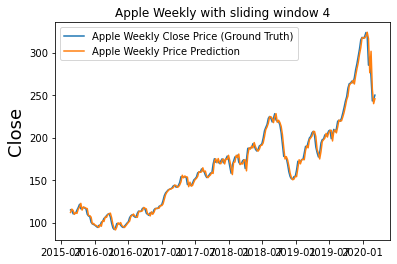

[[53 40]
 [46 99]]
Precision: 0.712
Recall: 0.683
Accuracy: 0.639
F1-score: 0.697



(5.268114187519143,
 0.7122302158273381,
 0.6827586206896552,
 0.6386554621848739,
 0.6971830985915493)

In [9]:
# ~ one month lag
linear_regression(name='Apple', df_stock=[df_aapl], lag=4)

Apple Weekly RMS: 5.301346140074838


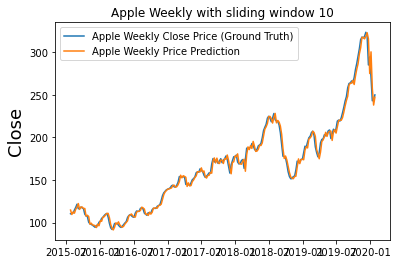

[[46 46]
 [50 94]]
Precision: 0.671
Recall: 0.653
Accuracy: 0.593
F1-score: 0.662



(5.301346140074838,
 0.6714285714285714,
 0.6527777777777778,
 0.5932203389830508,
 0.6619718309859155)

In [10]:
linear_regression(name='Apple', df_stock=[df_aapl], lag=10)

Apple Weekly RMS: 5.341107495742939


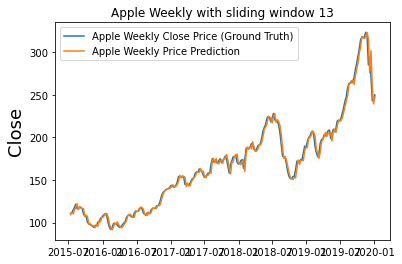

[[49 42]
 [54 90]]
Precision: 0.682
Recall: 0.625
Accuracy: 0.591
F1-score: 0.652



(5.341107495742939,
 0.6818181818181818,
 0.625,
 0.5914893617021276,
 0.6521739130434783)

In [11]:
# ~ one quarter
linear_regression(name='Apple', df_stock=[df_aapl], lag=13)

Apple Weekly RMS: 5.388281809830192


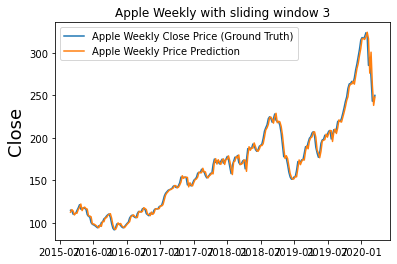

[[ 46  47]
 [ 40 105]]
Precision: 0.691
Recall: 0.724
Accuracy: 0.634
F1-score: 0.707



(5.388281809830192,
 0.6907894736842105,
 0.7241379310344828,
 0.634453781512605,
 0.7070707070707071)

In [12]:
linear_regression(name='Apple', df_stock=[df_aapl], lag=3)

4 weeks (one month) > 13 weeks > 10 weeks

## Google

Google Weekly RMS: 28.11445119425064


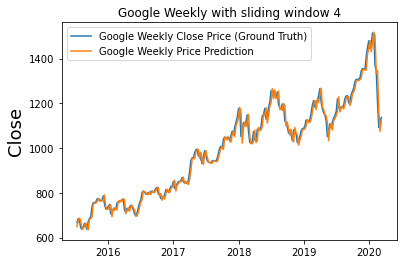

[[63 37]
 [72 72]]
Precision: 0.661
Recall: 0.500
Accuracy: 0.553
F1-score: 0.569



(28.11445119425064,
 0.6605504587155964,
 0.5,
 0.5532786885245902,
 0.5691699604743083)

In [13]:
linear_regression(name='Google', df_stock=[df_ggl], lag=4)

Google Weekly RMS: 28.249874413412865


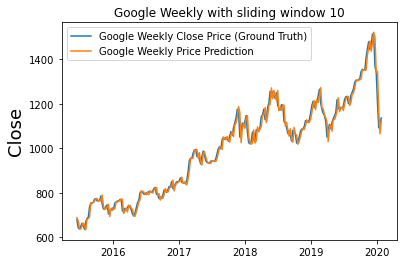

[[54 46]
 [61 81]]
Precision: 0.638
Recall: 0.570
Accuracy: 0.558
F1-score: 0.602



(28.249874413412865,
 0.6377952755905512,
 0.5704225352112676,
 0.5578512396694215,
 0.6022304832713754)

In [14]:
linear_regression(name='Google', df_stock=[df_ggl], lag=10)

Google Weekly RMS: 28.35547044639603


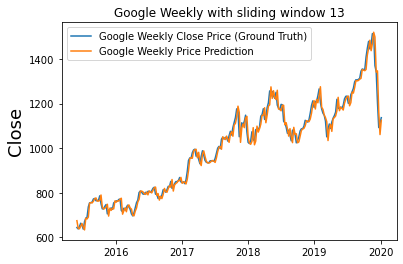

[[58 41]
 [64 78]]
Precision: 0.655
Recall: 0.549
Accuracy: 0.564
F1-score: 0.598



(28.35547044639603,
 0.6554621848739496,
 0.5492957746478874,
 0.5643153526970954,
 0.5977011494252874)

In [15]:
linear_regression(name='Google', df_stock=[df_ggl], lag=13)

## Microsoft

Microsoft Weekly RMS: 2.827443949566409


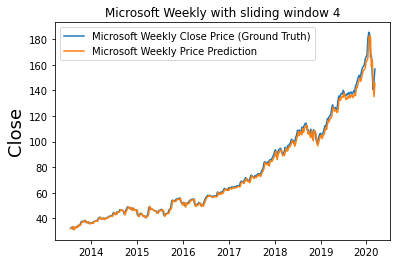

[[125   9]
 [199  14]]
Precision: 0.609
Recall: 0.066
Accuracy: 0.401
F1-score: 0.119



(2.827443949566409,
 0.6086956521739131,
 0.06572769953051644,
 0.40057636887608067,
 0.11864406779661017)

In [16]:
linear_regression(name='Microsoft', df_stock=[df_msft], lag=4)

Microsoft Weekly RMS: 2.6402655038742218


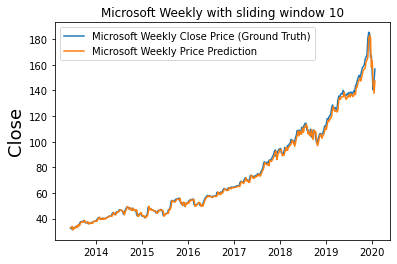

[[109  25]
 [174  38]]
Precision: 0.603
Recall: 0.179
Accuracy: 0.425
F1-score: 0.276



(2.6402655038742218,
 0.6031746031746031,
 0.1792452830188679,
 0.42485549132947975,
 0.27636363636363637)

In [17]:
linear_regression(name='Microsoft', df_stock=[df_msft], lag=10)

Microsoft Weekly RMS: 2.6440730093430953


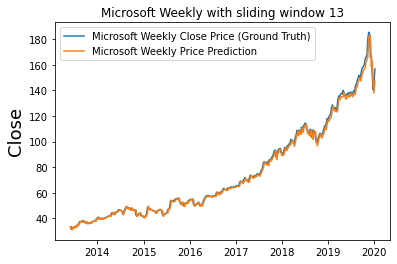

[[110  24]
 [176  35]]
Precision: 0.593
Recall: 0.166
Accuracy: 0.420
F1-score: 0.259



(2.6440730093430953,
 0.5932203389830508,
 0.16587677725118483,
 0.42028985507246375,
 0.25925925925925924)

In [18]:
linear_regression(name='Microsoft', df_stock=[df_msft], lag=13)

Microsoft Daily RMS: 1.7269256351794886


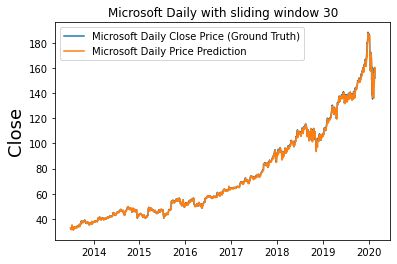

[[647 134]
 [734 155]]
Precision: 0.536
Recall: 0.174
Accuracy: 0.480
F1-score: 0.263



(1.7269256351794886,
 0.5363321799307958,
 0.17435320584926883,
 0.4802395209580838,
 0.2631578947368421)

In [19]:
linear_regression(name='Microsoft', df_stock=[df_msft], lag=30, aggr_fun='daily')

Microsoft Daily RMS: 1.7189803138055233


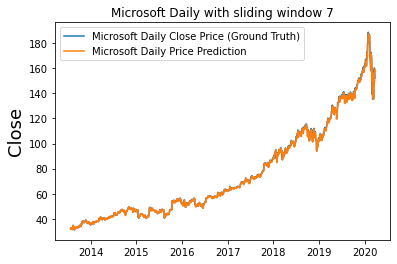

[[726  59]
 [828  64]]
Precision: 0.520
Recall: 0.072
Accuracy: 0.471
F1-score: 0.126



(1.7189803138055233,
 0.5203252032520326,
 0.07174887892376682,
 0.4710793082886106,
 0.12610837438423644)

In [20]:
linear_regression(name='Microsoft', df_stock=[df_msft], lag=7, aggr_fun='daily')

## Plot against performance & lag

In [21]:
def linear_regression_clean(name, df_stock, lag, aggr_fun='weekly'):
    train_stock, test_stock = generate_train_test(lag, df_stock, aggr_fun)

    model_stock = LinearRegression()
    x_train_stock = train_stock.drop(['Close (t)', 'movement'], axis=1)
    y_train_stock = train_stock['Close (t)']
    model_stock.fit(x_train_stock, y_train_stock)

    # features should exclude 'movement' and 'Close (t)'
    x_test_stock = test_stock.drop(['Close (t)', 'movement'], axis=1)
    y_test_stock = test_stock['Close (t)']

    preds_stock = model_stock.predict(x_test_stock)
    rms_stock = np.sqrt(np.mean(np.power((np.array(y_test_stock)-np.array(preds_stock)),2)))

    # plot
    df_results = pd.DataFrame()
    df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'] = test_stock['Close (t)']
    df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'] = preds_stock

    move_test_stock = test_stock['movement']

    pred_move_stock = (preds_stock - test_stock["Close (t-1)"]) 
    pred_move_stock = pred_move_stock.where(pred_move_stock<0, 1).where(pred_move_stock>=0, 0).astype(int)

    precision = precision_score(move_test_stock, pred_move_stock)
    recall = recall_score(move_test_stock, pred_move_stock)
    accuracy = accuracy_score(move_test_stock, pred_move_stock)
    f1 = f1_score(move_test_stock, pred_move_stock)
    
    return rms_stock, precision, recall, accuracy, f1
    

In [22]:
def plot_lag_to_performance(name, df_stock, aggr_fun='weekly'):
    rmss = []
    precisions = []
    recalls = []
    accuracies = []
    f1_scores = []

    lag_range = [i for i in range(1, 53)]
    
    # get performance df
    for i in lag_range:
        rms_stock, precision, recall, accuracy, f1_score = linear_regression_clean(name, df_stock, i, aggr_fun='weekly')
        rmss.append(rms_stock)
        precisions.append(precision)
        recalls.append(recall)
        accuracies.append(accuracy)
        f1_scores.append(f1_score)

    performances_arr = np.transpose(np.array([rmss, precisions, recalls, accuracies, f1_scores]))
    per_str = ['rmss', 'precisions', 'recalls', 'accuracies', 'f1_scores']
    df_perform = pd.DataFrame(data=performances_arr, index=lag_range, columns=per_str)
    
    # plotting performance against lag
    values = df_perform.values
    groups = range(0,5)
    i = 1
    plt.figure()
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(values[:, group])
        plt.title(df_perform.columns[group], y=0.5, loc='right')
        i += 1
    plt.show()
    
    return df_perform

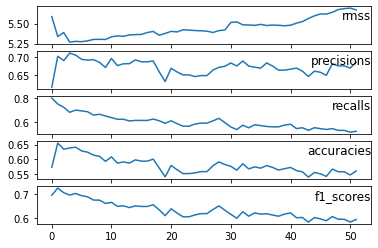

In [23]:
df_perform_aapl = plot_lag_to_performance(name='Apple', df_stock=[df_aapl])

In [24]:
df_perform_aapl  # 4 (1 month)

rmss  precisions   recalls  accuracies  f1_scores
1   5.587052    0.615789  0.801370    0.573222   0.696429
2   5.338191    0.703226  0.751724    0.655462   0.726667
3   5.388282    0.690789  0.724138    0.634454   0.707071
4   5.268114    0.712230  0.682759    0.638655   0.697183
5   5.277974    0.706294  0.701389    0.641350   0.703833
6   5.273838    0.694444  0.694444    0.628692   0.694444
7   5.284192    0.692308  0.687500    0.624473   0.689895
8   5.302232    0.693431  0.659722    0.614407   0.676157
9   5.303260    0.685714  0.666667    0.610169   0.676056
10  5.301346    0.671429  0.652778    0.593220   0.661972
11  5.335077    0.696970  0.638889    0.608511   0.666667
12  5.346133    0.676692  0.625000    0.587234   0.649819
13  5.341107    0.681818  0.625000    0.591489   0.652174
14  5.358139    0.682171  0.611111    0.587234   0.644689
15  5.362413    0.692913  0.615385    0.598291   0.651852
16  5.364528    0.687500  0.615385    0.594017   0.649446
17  5.387948    0.687500  0.615385    0.594017   0.649446
18  5.402065    0.689922  0.626761    0.600858   0.656827
19  5.353633    0.659091  0.612676    0.570815   0.635036
20  5.377244    0.631579  0.591549    0.540773   0.610909
21  5.402822    0.669231  0.612676    0.579399   0.639706
22  5.395908    0.658730  0.588652    0.564655   0.621723
23  5.422400    0.650407  0.567376    0.551724   0.606061
24  5.418521    0.650407  0.567376    0.551724   0.606061
25  5.412992    0.645669  0.585714    0.554113   0.614232
26  5.410520    0.648438  0.592857    0.558442   0.619403
27  5.405130    0.648438  0.592857    0.558442   0.619403
28  5.388634    0.664062  0.611511    0.578261   0.636704
29  5.411895    0.671756  0.633094    0.591304   0.651852
30  5.419763    0.674797  0.597122    0.582609   0.633588
31  5.514457    0.684211  0.561151    0.576419   0.616601
32  5.521161    0.675676  0.539568    0.563319   0.600000
33  5.484326    0.689655  0.575540    0.585153   0.627451
34  5.482629    0.675439  0.553957    0.567686   0.608696
35  5.477725    0.672269  0.579710    0.574561   0.622568
36  5.490014    0.669492  0.572464    0.570175   0.617188
37  5.475822    0.684211  0.565217    0.578947   0.619048
38  5.481434    0.675439  0.562044    0.572687   0.613546
39  5.478607    0.663793  0.562044    0.563877   0.608696
40  5.472704    0.663866  0.576642    0.568282   0.617187
41  5.479183    0.666667  0.583942    0.572687   0.622568
42  5.505358    0.669643  0.547445    0.561947   0.602410
43  5.524888    0.660870  0.554745    0.557522   0.603175
44  5.563277    0.646018  0.532847    0.539823   0.584000
45  5.596470    0.660870  0.554745    0.555556   0.603175
46  5.619627    0.657895  0.547445    0.551111   0.597610
47  5.618991    0.649123  0.540146    0.542222   0.589641
48  5.640727    0.681818  0.547445    0.566964   0.607287
49  5.674794    0.675926  0.532847    0.558036   0.595918
50  5.686605    0.675926  0.532847    0.558036   0.595918
51  5.693848    0.669811  0.518248    0.547085   0.584362
52  5.670628    0.685714  0.525547    0.560538   0.595041

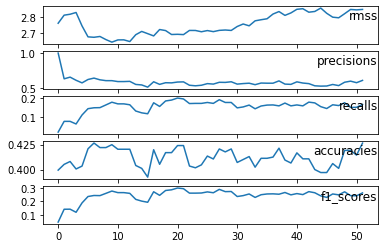

In [25]:
df_perform_msft = plot_lag_to_performance(name='Microsoft', df_stock=[df_msft])

In [26]:
df_perform_msft  # 7 (2 months?), generally lowest

rmss  precisions   recalls  accuracies  f1_scores
1   2.759626    1.000000  0.023364    0.399425   0.045662
2   2.810554    0.629630  0.079439    0.405172   0.141079
3   2.816391    0.653846  0.079439    0.408046   0.141667
4   2.827444    0.608696  0.065728    0.400576   0.118644
5   2.742523    0.571429  0.112676    0.403458   0.188235
6   2.673693    0.620000  0.145540    0.420749   0.235741
7   2.670958    0.640000  0.150235    0.426513   0.243346
8   2.676074    0.615385  0.150943    0.421965   0.242424
9   2.656405    0.603448  0.165094    0.421965   0.259259
10  2.640266    0.603175  0.179245    0.424855   0.276364
11  2.654304    0.590164  0.170616    0.420290   0.264706
12  2.654811    0.590164  0.170616    0.420290   0.264706
13  2.644073    0.593220  0.165877    0.420290   0.259259
14  2.687170    0.549020  0.133333    0.404070   0.214559
15  2.707907    0.541667  0.123810    0.401163   0.201550
16  2.693912    0.510204  0.119048    0.392442   0.193050
17  2.679554    0.587302  0.176190    0.419825   0.271062
18  2.719955    0.550000  0.157143    0.405248   0.244444
19  2.713344    0.573529  0.185714    0.416910   0.280576
20  2.688467    0.571429  0.190476    0.416910   0.285714
21  2.689787    0.583333  0.200957    0.423977   0.298932
22  2.687876    0.585714  0.196172    0.423977   0.293907
23  2.714191    0.537313  0.172249    0.403509   0.260870
24  2.713963    0.529412  0.173077    0.401760   0.260870
25  2.705843    0.537313  0.173077    0.404692   0.261818
26  2.713322    0.560606  0.177885    0.413490   0.270073
27  2.706601    0.553846  0.173077    0.410557   0.263736
28  2.714616    0.579710  0.192308    0.420588   0.288809
29  2.716854    0.578125  0.177885    0.417647   0.272059
30  2.714180    0.587302  0.177885    0.420588   0.273063
31  2.738988    0.553571  0.149758    0.407080   0.235741
32  2.754786    0.561404  0.154589    0.410029   0.242424
33  2.743293    0.566667  0.164251    0.412979   0.254682
34  2.774849    0.545455  0.144928    0.402367   0.229008
35  2.781677    0.568966  0.159420    0.411243   0.249057
36  2.787786    0.566667  0.164251    0.411243   0.254682
37  2.817640    0.566667  0.165049    0.412463   0.255639
38  2.833346    0.600000  0.160194    0.421365   0.252874
39  2.809221    0.553846  0.174757    0.409496   0.265683
40  2.824698    0.550000  0.160194    0.406528   0.248120
41  2.847622    0.586207  0.165049    0.416667   0.257576
42  2.851279    0.568966  0.160194    0.410714   0.250000
43  2.829271    0.560606  0.179612    0.410714   0.272059
44  2.833919    0.529412  0.175610    0.400000   0.263736
45  2.855373    0.524590  0.156098    0.397015   0.240602
46  2.822364    0.526316  0.146341    0.397015   0.229008
47  2.797910    0.548387  0.165854    0.405970   0.254682
48  2.793971    0.532258  0.161765    0.401198   0.248120
49  2.819787    0.580645  0.176471    0.419162   0.270677
50  2.846624    0.596154  0.151961    0.419162   0.242188
51  2.843884    0.574074  0.152709    0.414414   0.241245
52  2.846795    0.607143  0.167488    0.426426   0.262548

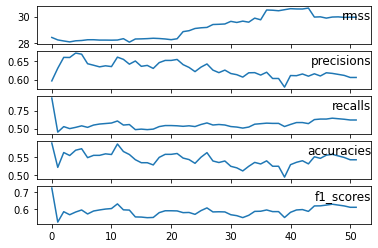

In [27]:
df_perform_ggl = plot_lag_to_performance(name='Google', df_stock=[df_ggl])

In [28]:
df_perform_ggl # 12 (around a quarter)

rmss  precisions   recalls  accuracies  f1_scores
1   28.447004    0.596413  0.923611    0.587755   0.724796
2   28.263378    0.631068  0.451389    0.520492   0.526316
3   28.184181    0.660870  0.527778    0.561475   0.586873
4   28.114451    0.660550  0.500000    0.553279   0.569170
5   28.195893    0.672727  0.517483    0.567901   0.584980
6   28.219431    0.669565  0.538462    0.572016   0.596899
7   28.274459    0.643478  0.517483    0.547325   0.573643
8   28.276236    0.639344  0.549296    0.553719   0.590909
9   28.249643    0.634921  0.563380    0.553719   0.597015
10  28.249874    0.637795  0.570423    0.557851   0.602230
11  28.243845    0.635659  0.577465    0.556017   0.605166
12  28.253444    0.661538  0.605634    0.585062   0.632353
13  28.355470    0.655462  0.549296    0.564315   0.597701
14  28.096277    0.642276  0.556338    0.556017   0.596226
15  28.331239    0.650943  0.485915    0.541667   0.556452
16  28.340948    0.636364  0.492958    0.533333   0.555556
17  28.358694    0.638889  0.485915    0.533333   0.552000
18  28.386400    0.630631  0.492958    0.527197   0.553360
19  28.366732    0.646552  0.528169    0.548117   0.581395
20  28.332778    0.652542  0.542254    0.556485   0.592308
21  28.280266    0.652542  0.542254    0.556485   0.592308
22  28.349055    0.655172  0.539007    0.558824   0.591440
23  28.879721    0.641026  0.531915    0.546218   0.581395
24  28.949811    0.633333  0.539007    0.542017   0.582375
25  29.115989    0.621849  0.528571    0.531646   0.571429
26  29.167341    0.634146  0.557143    0.548523   0.593156
27  29.195385    0.642857  0.578571    0.561181   0.609023
28  29.411658    0.626016  0.550000    0.538136   0.585551
29  29.428423    0.619048  0.557143    0.533898   0.586466
30  29.451888    0.626016  0.550000    0.538136   0.585551
31  29.647016    0.616667  0.528571    0.523404   0.569231
32  29.564279    0.613445  0.521429    0.519149   0.563707
33  29.663618    0.606838  0.507143    0.510638   0.552529
34  29.586106    0.618644  0.521429    0.523404   0.565891
35  29.887391    0.619048  0.561151    0.534188   0.588679
36  29.763833    0.612403  0.568345    0.529915   0.589552
37  30.495135    0.620155  0.575540    0.538462   0.597015
38  30.478159    0.603053  0.572464    0.523605   0.587361
39  30.438410    0.603053  0.572464    0.523605   0.587361
40  30.516720    0.579365  0.528986    0.493562   0.553030
41  30.593233    0.611111  0.557971    0.527897   0.583333
42  30.572928    0.610687  0.583942    0.534483   0.597015
43  30.568503    0.615385  0.583942    0.538793   0.599251
44  30.639074    0.609375  0.569343    0.530172   0.588679
45  29.966788    0.615942  0.625000    0.549784   0.620438
46  29.985185    0.609929  0.632353    0.545455   0.620939
47  29.888965    0.618705  0.632353    0.554113   0.625455
48  29.969431    0.617021  0.644444    0.556522   0.630435
49  29.982467    0.614286  0.637037    0.552174   0.625455
50  29.945297    0.611511  0.629630    0.547826   0.620438
51  29.956394    0.605839  0.619403    0.541485   0.612546
52  29.956500    0.605839  0.619403    0.541485   0.612546

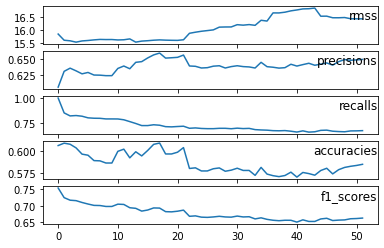

In [29]:
df_perform_all = plot_lag_to_performance(name='All', df_stock=[df_aapl, df_ggl, df_msft])

In [30]:
df_perform_all  # 18

rmss  precisions   recalls  accuracies  f1_scores
1   15.843534    0.605769  1.000000    0.605769   0.754491
2   15.602562    0.630882  0.852883    0.608434   0.725275
3   15.579829    0.635945  0.823062    0.607229   0.717504
4   15.527671    0.631659  0.826693    0.603136   0.716135
5   15.574887    0.626911  0.820000    0.596131   0.710572
6   15.592781    0.629108  0.804000    0.594921   0.705882
7   15.615992    0.625000  0.800000    0.588875   0.701754
8   15.634047    0.624804  0.799197    0.588592   0.701322
9   15.628629    0.624013  0.793173    0.586165   0.698497
10  15.629598    0.624013  0.793173    0.586165   0.698497
11  15.613232    0.635484  0.792757    0.599269   0.705461
12  15.620448    0.639344  0.784708    0.601705   0.704607
13  15.653952    0.635000  0.766600    0.591961   0.694622
14  15.528170    0.645217  0.747984    0.598780   0.692810
15  15.568596    0.646320  0.727273    0.594132   0.684411
16  15.583969    0.652174  0.727273    0.600244   0.687679
17  15.603442    0.657040  0.735354    0.607099   0.693994
18  15.615746    0.659963  0.730769    0.608589   0.693564
19  15.605722    0.651934  0.716599    0.596319   0.682739
20  15.600200    0.652495  0.714575    0.596319   0.682126
21  15.596887    0.653137  0.718053    0.598280   0.684058
22  15.620565    0.656772  0.720978    0.603448   0.687379
23  15.873559    0.639405  0.700611    0.580049   0.668610
24  15.916004    0.638889  0.704082    0.580764   0.669903
25  15.952516    0.636194  0.698770    0.577256   0.666016
26  15.979288    0.636704  0.696721    0.577256   0.665362
27  16.006805    0.639098  0.696721    0.579728   0.666667
28  16.113751    0.639775  0.700205    0.580645   0.668627
29  16.119996    0.636194  0.700205    0.576923   0.666667
30  16.121308    0.638418  0.696099    0.578164   0.666012
31  16.209803    0.639775  0.701646    0.580324   0.669284
32  16.190891    0.638418  0.697531    0.577833   0.666667
33  16.213573    0.637899  0.699588    0.577833   0.667321
34  16.184477    0.636190  0.687243    0.572319   0.660732
35  16.381875    0.645224  0.683884    0.581250   0.663992
36  16.351046    0.638298  0.681818    0.573750   0.659341
37  16.669530    0.637427  0.677019    0.571965   0.656627
38  16.668614    0.636008  0.675676    0.570891   0.655242
39  16.697250    0.636719  0.677755    0.572146   0.656596
40  16.749993    0.642147  0.671518    0.575910   0.656504
41  16.784626    0.639279  0.663202    0.570352   0.651020
42  16.825651    0.641584  0.675000    0.575567   0.657868
43  16.832979    0.643725  0.662500    0.574307   0.652977
44  16.858730    0.640562  0.665971    0.572509   0.653019
45  16.540362    0.642292  0.679916    0.577750   0.660569
46  16.542347    0.644269  0.682008    0.580278   0.662602
47  16.480419    0.640719  0.671548    0.573957   0.655771
48  16.479790    0.646341  0.668067    0.578680   0.657025
49  16.489036    0.649590  0.665966    0.581218   0.657676
50  16.442934    0.648485  0.674370    0.582487   0.661174
51  16.439373    0.649087  0.675105    0.583439   0.661841
52  16.438246    0.649798  0.677215    0.584713   0.663223

## All

In [31]:
train_all, test_all = generate_train_test(18, datasets=[df_aapl, df_ggl, df_msft])
_, test_aapl = generate_train_test(18, datasets=[df_aapl])
_, test_ggl = generate_train_test(18, datasets=[df_ggl])
_, test_msft = generate_train_test(18, datasets=[df_msft])

model_all = LinearRegression()
x_train_all = train_all.drop(['Close (t)', 'movement'], axis=1)
y_train_all = train_all['Close (t)']
model_all.fit(x_train_all, y_train_all)


LinearRegression()

### Test

Apple-All RMS: 5.242276809633768


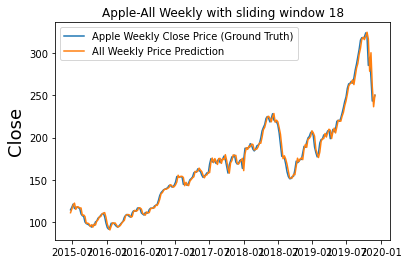

[[ 48  43]
 [ 30 112]]
Precision: 0.723
Recall: 0.789
Accuracy: 0.687
F1-score: 0.754



In [32]:
# AAPL
x_test_aapl = test_aapl.drop(['Close (t)', 'movement'], axis=1)
y_test_aapl = test_aapl['Close (t)']

preds_aapl = model_all.predict(x_test_aapl)
rms_aapl = np.sqrt(np.mean(np.power((np.array(y_test_aapl)-np.array(preds_aapl)),2)))

print('Apple-All', 'RMS:', rms_aapl)

# plot
df_results = pd.DataFrame()
df_results['Apple Weekly Close Price (Ground Truth)'] = test_aapl['Close (t)']
df_results['All Weekly Price Prediction'] = preds_aapl

plt.plot(df_results['Apple Weekly Close Price (Ground Truth)'])
plt.plot(df_results['All Weekly Price Prediction'])

plt.title('Apple-All Weekly with sliding window '+str(18))

plt.ylabel('Close',fontsize=18)
plt.legend(['Apple Weekly Close Price (Ground Truth)', 'All Weekly Price Prediction'])
plt.show()

move_test_aapl = test_aapl['movement']

pred_move_aapl = (preds_aapl - test_aapl["Close (t-1)"])
pred_move_aapl = pred_move_aapl.where(pred_move_aapl<0, 1).where(pred_move_aapl>=0, 0).astype(int)

precision = precision_score(move_test_aapl, pred_move_aapl)
recall = recall_score(move_test_aapl, pred_move_aapl)
accuracy = accuracy_score(move_test_aapl, pred_move_aapl)
f1 = f1_score(move_test_aapl, pred_move_aapl)

print(confusion_matrix(move_test_aapl, pred_move_aapl))
print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)
print('Accuracy: %.3f' % accuracy)
print('F1-score: %.3f\n' % f1)

Google-All RMS: 28.225207372881115


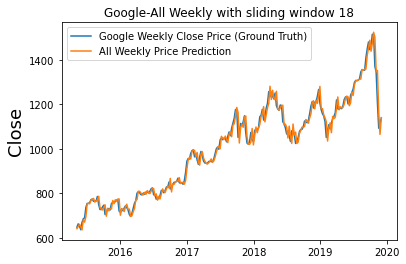

[[49 48]
 [48 94]]
Precision: 0.662
Recall: 0.662
Accuracy: 0.598
F1-score: 0.662



In [33]:
# GGL
x_test_ggl = test_ggl.drop(['Close (t)', 'movement'], axis=1)
y_test_ggl = test_ggl['Close (t)']

preds_ggl = model_all.predict(x_test_ggl)
rms_ggl = np.sqrt(np.mean(np.power((np.array(y_test_ggl)-np.array(preds_ggl)),2)))

print('Google-All', 'RMS:', rms_ggl)

# plot
df_results = pd.DataFrame()
df_results['Google Weekly Close Price (Ground Truth)'] = test_ggl['Close (t)']
df_results['All Weekly Price Prediction'] = preds_ggl

plt.plot(df_results['Google Weekly Close Price (Ground Truth)'])
plt.plot(df_results['All Weekly Price Prediction'])

plt.title('Google-All Weekly with sliding window '+str(18))

plt.ylabel('Close',fontsize=18)
plt.legend(['Google Weekly Close Price (Ground Truth)', 'All Weekly Price Prediction'])
plt.show()


move_test_ggl = test_ggl['movement']

pred_move_ggl = (preds_ggl - test_ggl["Close (t-1)"])
pred_move_ggl = pred_move_ggl.where(pred_move_ggl<0, 1).where(pred_move_ggl>=0, 0).astype(int)

precision = precision_score(move_test_ggl, pred_move_ggl)
recall = recall_score(move_test_ggl, pred_move_ggl)
accuracy = accuracy_score(move_test_ggl, pred_move_ggl)
f1 = f1_score(move_test_ggl, pred_move_ggl)

print(confusion_matrix(move_test_ggl, pred_move_ggl))
print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)
print('Accuracy: %.3f' % accuracy)
print('F1-score: %.3f\n' % f1)

Microsoft-All RMS: 2.3742449931399454


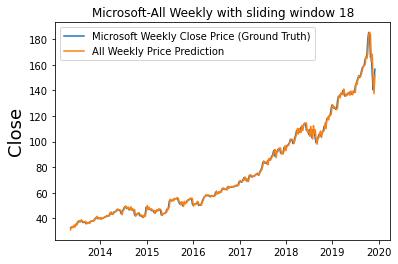

[[ 38  95]
 [ 55 155]]
Precision: 0.620
Recall: 0.738
Accuracy: 0.563
F1-score: 0.674



In [34]:
# MSFT
x_test_msft = test_msft.drop(['Close (t)', 'movement'], axis=1)
y_test_msft = test_msft['Close (t)']

preds_msft = model_all.predict(x_test_msft)
rms_msft = np.sqrt(np.mean(np.power((np.array(y_test_msft)-np.array(preds_msft)),2)))

print('Microsoft-All', 'RMS:', rms_msft)

# plot
df_results = pd.DataFrame()
df_results['Microsoft Weekly Close Price (Ground Truth)'] = test_msft['Close (t)']
df_results['All Weekly Price Prediction'] = preds_msft

plt.plot(df_results['Microsoft Weekly Close Price (Ground Truth)'])
plt.plot(df_results['All Weekly Price Prediction'])

plt.title('Microsoft-All Weekly with sliding window '+str(18))

plt.ylabel('Close',fontsize=18)
plt.legend(['Microsoft Weekly Close Price (Ground Truth)', 'All Weekly Price Prediction'])
plt.show()

move_test_msft = test_msft['movement']

pred_move_msft = (preds_msft - test_msft["Close (t-1)"])
pred_move_msft = pred_move_msft.where(pred_move_msft<0, 1).where(pred_move_msft>=0, 0).astype(int)

precision = precision_score(move_test_msft, pred_move_msft)
recall = recall_score(move_test_msft, pred_move_msft)
accuracy = accuracy_score(move_test_msft, pred_move_msft)
f1 = f1_score(move_test_msft, pred_move_msft)

print(confusion_matrix(move_test_msft, pred_move_msft))
print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)
print('Accuracy: %.3f' % accuracy)
print('F1-score: %.3f\n' % f1)